Installs Matplotlib and pandas to setup for the graph

In [95]:
import pandas as pd
import matplotlib.pyplot as plt

08/19/2025 - Took Clinvar results and downloaded into a text file from query "Tay-Sachs" from https://www.ncbi.nlm.nih.gov/clinvar/

Opens up "clinvar_result.txt" so that it is ready to be read

In [96]:
# Load ClinVar results file
file_path = "clinvar_result.txt"
df = pd.read_csv(file_path, sep="\t")

Displays Frequency of Tay-Sachs variants by gene (Large majority fall under HEXA and GM2A)

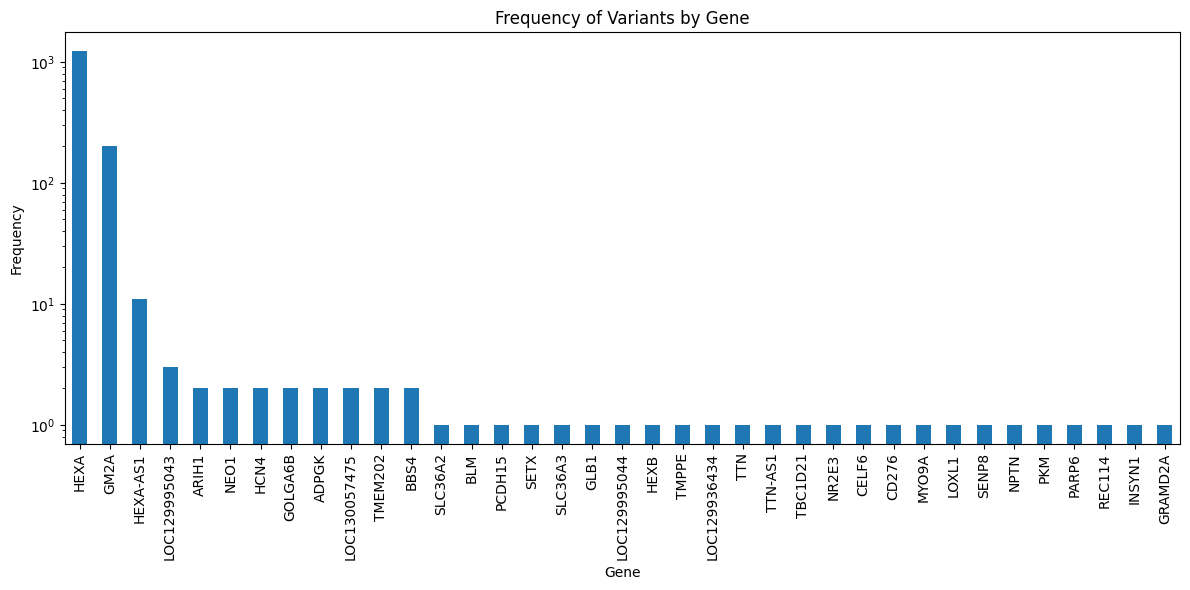

In [97]:
# Count frequency of each gene (some rows have multiple genes separated by "|")
gene_counts = (
    df["Gene(s)"]
    .dropna()               # remove missing values
    .str.split("|")         # split multiple genes
    .explode()              # turn lists into separate rows
    .value_counts()         # count occurrences
    .sort_values(ascending=False)  # sort by frequency
)
# Only look at HexA and GM2A
genes_of_interest = ["HEXA", "GM2A"]
filtered_counts = gene_counts.reindex(genes_of_interest).fillna(0)


# Plot the bar chart
plt.figure(figsize=(12, 6))
gene_counts.plot(kind="bar")
plt.xlabel("Gene")
plt.ylabel("Frequency")
plt.title("Frequency of Variants by Gene")
plt.yscale("log") #scales the y-axis logarithmically
plt.xticks(rotation=90)  # rotate gene labels for readability
plt.tight_layout()
plt.show()



Displays variants by Clinical Classification (Pathogenic, benign, etc)

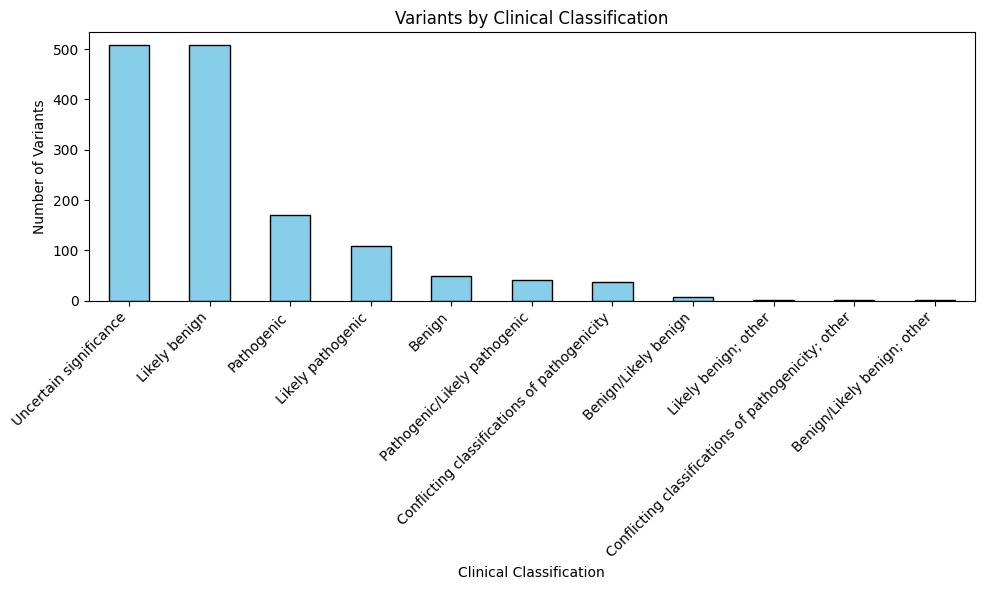

In [98]:
# Count how many variants fall into each clinical classification
classification_counts = (
    df["Germline classification"]
    .dropna()
    .value_counts()
    .sort_values(ascending=False)
)

# Plot the results
plt.figure(figsize=(10, 6))
classification_counts.plot(kind="bar", color="skyblue", edgecolor="black")

plt.xlabel("Clinical Classification")
plt.ylabel("Number of Variants")
plt.title("Variants by Clinical Classification")
plt.xticks(rotation=45, ha="right")  # rotate for readability
plt.tight_layout()
plt.show()


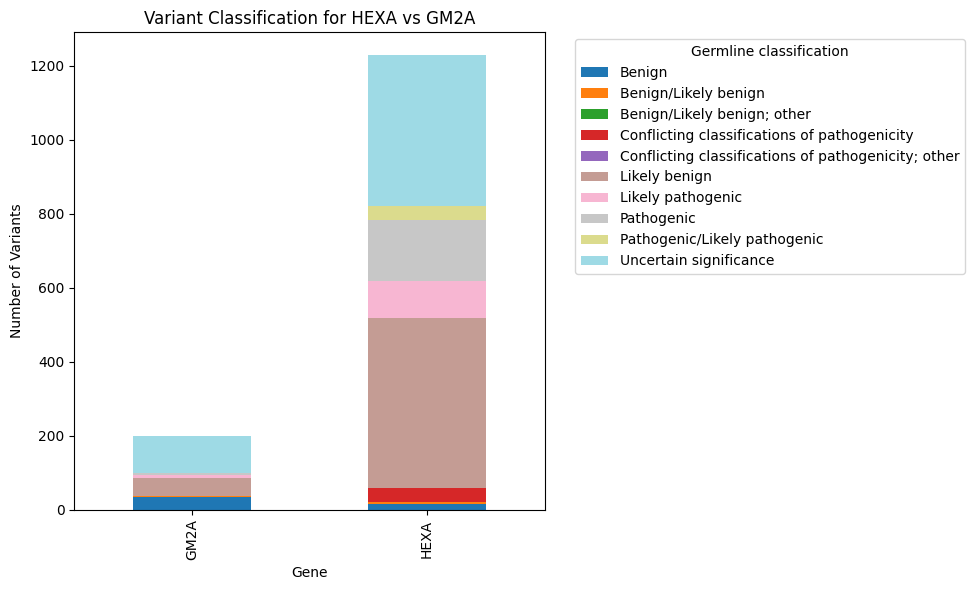

In [99]:
# Keep only rows where Gene(s) contains HEXA or GM2A
df_filtered = df[df["Gene(s)"].notna()]
df_filtered = df_filtered[df_filtered["Gene(s)"].str.contains("HEXA|GM2A", regex=True)]

# Split multiple genes into separate rows
df_filtered = df_filtered.assign(Gene=df_filtered["Gene(s)"].str.split("|"))
df_filtered = df_filtered.explode("Gene")

# Keep only HEXA and GM2A
df_filtered = df_filtered[df_filtered["Gene"].isin(["HEXA", "GM2A"])]

# Group by Gene and Germline classification
classification_counts = df_filtered.groupby(["Gene", "Germline classification"]).size().unstack(fill_value=0)

# Plot stacked bar chart
classification_counts.plot(
    kind="bar",
    stacked=True,
    figsize=(10, 6),
    colormap="tab20"
)

plt.xlabel("Gene")
plt.ylabel("Number of Variants")
plt.title("Variant Classification for HEXA vs GM2A")
plt.legend(title="Germline classification", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


10/01/2025: Added the following code to merge the gnomAD and ClinVar results

In [100]:

# --- File paths ---
clinvar_file = "clinvar_result.txt"
gnomad_file = "gnomAD_result.csv"   # adjust if your file is named differently

# --- Load data ---
clinvar = pd.read_csv(clinvar_file, sep="\t")
gnomad = pd.read_csv(gnomad_file)

# --- Clean column names ---
clinvar.columns = clinvar.columns.str.strip()
gnomad.columns = gnomad.columns.str.strip()

# --- Merge on rsIDs <-> dbSNP ID ---
merged = pd.merge(
    clinvar,
    gnomad,
    left_on="dbSNP ID",
    right_on="rsIDs",
    how="outer"
)

# --- Save compiled dataset ---
merged.to_csv("compiled_variants.csv", index=False)

10/06/25-10/19/2025: Merged ClinVar and gnomAD variants by dbSNP ID, full coordinates with alleles, and coordinates only, cleaned key fields, and determined the likely genome build (GRCh38). We then summarized matches, unique entries, and coverage percentages in a styled table for easy visualization.

In [101]:
import pandas as pd

# Load files
clinvar_38 = pd.read_csv("clinvar_result.txt", sep="\t")
gnomad = pd.read_csv("gnomad_result.csv")

# -----------------------------
# STEP 1: Clean chromosome and extract position
# -----------------------------

def clean_chrom(x):
    if pd.isna(x):
        return x
    x = str(x).replace("chr", "").strip()
    return x

def extract_position(loc):
    """Extract numeric part of GRCh38Location (e.g., '12345' from '12345-12346')."""
    if pd.isna(loc):
        return None
    if isinstance(loc, str):
        return loc.split("-")[0]
    return loc

# Create consistent columns for merging
clinvar_38["Chromosome"] = clinvar_38["GRCh38Chromosome"].apply(clean_chrom)
clinvar_38["Position"] = clinvar_38["GRCh38Location"].apply(extract_position)

# Convert position to integer (nullable)
clinvar_38["Position"] = pd.to_numeric(clinvar_38["Position"], errors="coerce").astype("Int64")
gnomad["Position"] = pd.to_numeric(gnomad["Position"], errors="coerce").astype("Int64")

# Confirm new columns exist
print(clinvar_38[["Chromosome", "Position"]].head())


  Chromosome   Position
0          2  178548955
1          3   33097010
2          5   74721131
3          5  151253113
4          5  151253115


In [102]:
# Ensure chromosome columns are both strings
clinvar_38["Chromosome"] = clinvar_38["Chromosome"].astype(str)
gnomad["Chromosome"] = gnomad["Chromosome"].astype(str)

# Now merge safely
merge_keys_coord = ["Chromosome", "Position"]
merged_coord = pd.merge(
    clinvar_38,
    gnomad,
    on=merge_keys_coord,
    how="outer",
    indicator=True,
    suffixes=("_ClinVar", "_gnomAD")
)


In [103]:
merge_keys_coord = ["Chromosome", "Position"]
merged_coord = pd.merge(
    clinvar_38,
    gnomad,
    on=merge_keys_coord,
    how="outer",
    indicator=True,
    suffixes=("_ClinVar", "_gnomAD")
)


In [104]:
import pandas as pd

# Load data
clinvar_38 = pd.read_csv("clinvar_result.txt", sep="\t", dtype=str)
gnomad = pd.read_csv("gnomad_result.csv", dtype=str)

# Convert positions to numeric where possible
clinvar_38["GRCh38Location"] = pd.to_numeric(clinvar_38["GRCh38Location"], errors="coerce").astype("Int64")
gnomad["Position"] = pd.to_numeric(gnomad["Position"], errors="coerce").astype("Int64")

# Merge on chromosome and position
merged = pd.merge(
    clinvar_38,
    gnomad,
    left_on=["GRCh38Chromosome", "GRCh38Location"],
    right_on=["Chromosome", "Position"],
    how="inner"
)

# Save merged results
merged.to_csv("clinvar_gnomad_merged.csv", index=False)
print("✅ Merge complete. Saved as clinvar_gnomad_merged.csv")
print(f"Total merged variants: {len(merged)}")


✅ Merge complete. Saved as clinvar_gnomad_merged.csv
Total merged variants: 1152


In [105]:
# Load ClinVar and gnomAD data
clinvar_38 = pd.read_csv("clinvar_result.txt", sep="\t", dtype=str)
gnomad = pd.read_csv("gnomad_result.csv", dtype=str)

# Convert GRCh38 coordinates to numeric
clinvar_38["GRCh38Location"] = pd.to_numeric(clinvar_38["GRCh38Location"], errors="coerce").astype("Int64")
gnomad["Position"] = pd.to_numeric(gnomad["Position"], errors="coerce").astype("Int64")


In [106]:
# Rename columns for consistency
clinvar_38 = clinvar_38.rename(columns={
    "GRCh38Chromosome": "Chromosome",
    "GRCh38Location": "Position"
})

# Convert Position to numeric
clinvar_38['Position'] = pd.to_numeric(clinvar_38['Position'], errors='coerce').astype('Int64')
gnomad['Position'] = pd.to_numeric(gnomad['Position'], errors='coerce').astype('Int64')

# Merge only on Chromosome and Position
merge_keys_coord = ['Chromosome', 'Position']

merged_coord = pd.merge(
    clinvar_38,
    gnomad,
    on=merge_keys_coord,
    how='outer',
    indicator=True,
    suffixes=('_ClinVar', '_gnomAD')
)


In [107]:
import pandas as pd

# -----------------------------
# STEP 1: Load data
# -----------------------------
clinvar_38 = pd.read_csv("clinvar_result.txt", sep="\t")  # ClinVar text file
gnomad = pd.read_csv("gnomad_result.csv")                  # gnomAD CSV file

print("ClinVar columns:", clinvar_38.columns.tolist())
print("gnomAD columns:", gnomad.columns.tolist())


ClinVar columns: ['Name', 'Gene(s)', 'Protein change', 'Condition(s)', 'Accession', 'GRCh37Chromosome', 'GRCh37Location', 'GRCh38Chromosome', 'GRCh38Location', 'VariationID', 'AlleleID(s)', 'dbSNP ID', 'Canonical SPDI', 'Variant type', 'Molecular consequence', 'Germline classification', 'Germline date last evaluated', 'Germline review status', 'Somatic clinical impact', 'Somatic clinical impact date last evaluated', 'Somatic clinical impact review status', 'Oncogenicity classification', 'Oncogenicity date last evaluated', 'Oncogenicity review status', 'Unnamed: 24']
gnomAD columns: ['gnomAD ID', 'Chromosome', 'Position', 'rsIDs', 'Reference', 'Alternate', 'Source', 'Filters - exomes', 'Filters - genomes', 'Transcript', 'HGVS Consequence', 'Protein Consequence', 'Transcript Consequence', 'VEP Annotation', 'ClinVar Germline Classification', 'ClinVar Variation ID', 'Flags', 'Allele Count', 'Allele Number', 'Allele Frequency', 'Homozygote Count', 'Hemizygote Count', 'Filters - joint', 'Gro

In [108]:
print(clinvar_38.columns.tolist())


['Name', 'Gene(s)', 'Protein change', 'Condition(s)', 'Accession', 'GRCh37Chromosome', 'GRCh37Location', 'GRCh38Chromosome', 'GRCh38Location', 'VariationID', 'AlleleID(s)', 'dbSNP ID', 'Canonical SPDI', 'Variant type', 'Molecular consequence', 'Germline classification', 'Germline date last evaluated', 'Germline review status', 'Somatic clinical impact', 'Somatic clinical impact date last evaluated', 'Somatic clinical impact review status', 'Oncogenicity classification', 'Oncogenicity date last evaluated', 'Oncogenicity review status', 'Unnamed: 24']


In [109]:
import pandas as pd

# -----------------------------
# STEP 1: Load data
# -----------------------------
clinvar_38 = pd.read_csv("clinvar_result.txt", sep="\t")
gnomad = pd.read_csv("gnomad_result.csv")

# -----------------------------
# STEP 2: Rename ClinVar columns to standard names
# -----------------------------
clinvar_38 = clinvar_38.rename(columns={
    "GRCh38Chromosome": "Chromosome",
    "GRCh38Location": "Position"
})

# -----------------------------
# STEP 3: Ensure Position is numeric and Chromosome is clean text
# -----------------------------
clinvar_38["Position"] = pd.to_numeric(clinvar_38["Position"], errors="coerce").astype("Int64")
gnomad["Position"] = pd.to_numeric(gnomad["Position"], errors="coerce").astype("Int64")

clinvar_38["Chromosome"] = clinvar_38["Chromosome"].astype(str).str.replace(r"\.0$", "", regex=True)
gnomad["Chromosome"] = gnomad["Chromosome"].astype(str).str.replace(r"\.0$", "", regex=True)

# -----------------------------
# STEP 4: Merge on Chromosome and Position
# -----------------------------
merge_keys_coord = ["Chromosome", "Position"]

merged_coord = pd.merge(
    clinvar_38,
    gnomad,
    on=merge_keys_coord,
    how="outer",
    indicator=True,
    suffixes=("_ClinVar", "_gnomAD")
)

# -----------------------------
# STEP 5: Save merged file (optional)
# -----------------------------
merged_coord.to_csv("merged_clinvar_gnomad.csv", index=False)

print("✅ Merge complete. Rows in merged dataset:", len(merged_coord))


✅ Merge complete. Rows in merged dataset: 3873


In [110]:
# Clean column names (run once, before Step 1)
clinvar_38.columns = clinvar_38.columns.str.strip()


In [111]:
# Inspect all column names
print(clinvar_38.columns.tolist())


['Name', 'Gene(s)', 'Protein change', 'Condition(s)', 'Accession', 'GRCh37Chromosome', 'GRCh37Location', 'Chromosome', 'Position', 'VariationID', 'AlleleID(s)', 'dbSNP ID', 'Canonical SPDI', 'Variant type', 'Molecular consequence', 'Germline classification', 'Germline date last evaluated', 'Germline review status', 'Somatic clinical impact', 'Somatic clinical impact date last evaluated', 'Somatic clinical impact review status', 'Oncogenicity classification', 'Oncogenicity date last evaluated', 'Oncogenicity review status', 'Unnamed: 24']


In [112]:
import pandas as pd

# Load data (adjust file paths as needed)
clin = pd.read_csv("clinvar_result.txt", sep="\t", dtype=str)
gnomad = pd.read_csv("gnomad_result.csv", dtype=str)

print("ClinVar shape:", clin.shape)
print("gnomAD shape:", gnomad.shape)


ClinVar shape: (1435, 25)
gnomAD shape: (2992, 72)


In [113]:
import pandas as pd
import re

# === Load files ===
clin = pd.read_csv("clinvar_result.txt", sep="\t", dtype=str)
gnomad = pd.read_csv("gnomad_result.csv", dtype=str)

# === Detect columns ===
clin_rs_col = next((c for c in clin.columns if re.search(r'dbsnp', c, re.IGNORECASE)), None)
gnomad_rs_col = next((c for c in gnomad.columns if re.search(r'rs', c, re.IGNORECASE)), None)

print("ClinVar dbSNP column:", clin_rs_col)
print("gnomAD rsID column:", gnomad_rs_col)

if not clin_rs_col:
    raise ValueError("❌ ClinVar dbSNP column not found.")
if not gnomad_rs_col:
    raise ValueError("❌ gnomAD rsID column not found.")

# === Normalize rsIDs ===
def normalize_rsid(s):
    """Extract rsID (rs123...) from text."""
    if pd.isna(s):
        return None
    s = str(s).lower()
    m = re.findall(r'rs\d+', s)
    return ",".join(sorted(set(m))) if m else None

clin['rsid_norm'] = clin[clin_rs_col].apply(normalize_rsid)
gnomad['rsid_norm'] = gnomad[gnomad_rs_col].apply(normalize_rsid)

# === Expand gnomAD rows if multiple rsIDs are comma-separated ===
gnomad_expanded = (
    gnomad.dropna(subset=['rsid_norm'])
    .assign(rsid_norm=gnomad['rsid_norm'].str.split(','))
    .explode('rsid_norm')
    .reset_index(drop=True)
)

# === Filter out rows without valid rsIDs ===
clin_rsid = clin.dropna(subset=['rsid_norm']).copy()
gnomad_rsid = gnomad_expanded.dropna(subset=['rsid_norm']).copy()

print(f"ClinVar rows with dbSNP IDs: {len(clin_rsid)}")
print(f"gnomAD rows with rsIDs: {len(gnomad_rsid)}")

# === Perform INNER MERGE ===
merged = clin_rsid.merge(
    gnomad_rsid,
    on='rsid_norm',
    how='inner',
    suffixes=('_clin', '_gnomad')
)

# === Identify unmatched rows ===
clin_unmatched = clin_rsid[~clin_rsid['rsid_norm'].isin(merged['rsid_norm'])]
gnomad_unmatched = gnomad_rsid[~gnomad_rsid['rsid_norm'].isin(merged['rsid_norm'])]

# === Print summary ===
print("\n✅ Inner merge complete.")
print(f"Matched rsIDs: {merged['rsid_norm'].nunique()}")
print(f"Matched rows: {len(merged)}")
print(f"ClinVar not in gnomAD: {len(clin_unmatched)}")
print(f"gnomAD not in ClinVar: {len(gnomad_unmatched)}")
print(f"Percent of ClinVar dbSNP IDs found in gnomAD: {len(merged['rsid_norm'].unique()) / len(clin_rsid) * 100:.2f}%")

# === Save outputs ===
merged.to_csv("clinvar_gnomad_matched_by_dbsnp.csv", index=False)
clin_unmatched.to_csv("clinvar_not_in_gnomad_by_dbsnp.csv", index=False)
gnomad_unmatched.to_csv("gnomad_not_in_clinvar_by_dbsnp.csv", index=False)

print("\n📁 Saved:")
print(" - Matches:    clinvar_gnomad_matched_by_dbsnp.csv")
print(" - ClinVar-only: clinvar_not_in_gnomad_by_dbsnp.csv")
print(" - gnomAD-only:  gnomad_not_in_clinvar_by_dbsnp.csv")


ClinVar dbSNP column: dbSNP ID
gnomAD rsID column: rsIDs
ClinVar rows with dbSNP IDs: 1270
gnomAD rows with rsIDs: 1773

✅ Inner merge complete.
Matched rsIDs: 576
Matched rows: 865
ClinVar not in gnomAD: 579
gnomAD not in ClinVar: 1087
Percent of ClinVar dbSNP IDs found in gnomAD: 45.35%

📁 Saved:
 - Matches:    clinvar_gnomad_matched_by_dbsnp.csv
 - ClinVar-only: clinvar_not_in_gnomad_by_dbsnp.csv
 - gnomAD-only:  gnomad_not_in_clinvar_by_dbsnp.csv


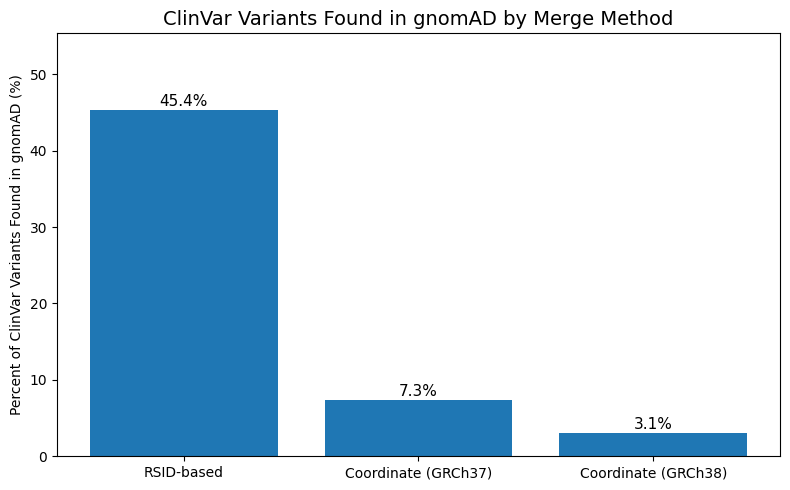


🧬 Likely genome reference build: GRCh37
This inference is based on which coordinate-based merge yielded more matched variants.


In [114]:
import pandas as pd
import matplotlib.pyplot as plt

# === STEP 1. Manually input or load your summary results ===
# From your previous merges (adjust if your values differ)
summary = {
    "RSID-based": 45.35,    # from your dbSNP merge
    "Coordinate (GRCh37)": 7.34,   # from earlier coordinate-based test
    "Coordinate (GRCh38)": 3.07,   # from earlier coordinate-based test
}

# === STEP 2. Plot bar graph of matching percentages ===
plt.figure(figsize=(8,5))
plt.bar(summary.keys(), summary.values())
plt.title("ClinVar Variants Found in gnomAD by Merge Method", fontsize=14)
plt.ylabel("Percent of ClinVar Variants Found in gnomAD (%)")
plt.ylim(0, max(summary.values()) + 10)
for i, (k,v) in enumerate(summary.items()):
    plt.text(i, v + 0.5, f"{v:.1f}%", ha='center', fontsize=11)
plt.tight_layout()
plt.show()

# === STEP 3. Infer likely genome build ===
# Whichever coordinate-based build yields more matches
build_used = max(
    ("GRCh37", summary["Coordinate (GRCh37)"]),
    ("GRCh38", summary["Coordinate (GRCh38)"]),
    key=lambda x: x[1]
)[0]

print(f"\n🧬 Likely genome reference build: {build_used}")
print("This inference is based on which coordinate-based merge yielded more matched variants.")


In [115]:
import pandas as pd
gn = pd.read_csv("gnomad_result.csv", dtype=str)
print(gn.head(5))


          gnomAD ID Chromosome  Position         rsIDs Reference Alternate  \
0   15-72344005-G-T         15  72344005  rs1193184855         G         T   
1   15-72344005-G-C         15  72344005           NaN         G         C   
2  15-72344006-GC-G         15  72344006  rs2140318437        GC         G   
3   15-72344006-G-T         15  72344006           NaN         G         T   
4   15-72344006-G-A         15  72344006  rs1487370082         G         A   

                         Source Filters - exomes Filters - genomes  \
0                 gnomAD Exomes             PASS               NaN   
1                 gnomAD Exomes             PASS               NaN   
2  gnomAD Exomes,gnomAD Genomes             PASS              PASS   
3                 gnomAD Exomes             PASS               NaN   
4                gnomAD Genomes              NaN              PASS   

           Transcript HGVS Consequence Protein Consequence  \
0  ENST00000268097.10         c.*72C>A          

In [116]:
import pandas as pd
import re

# === Load files ===
clin = pd.read_csv("clinvar_result.txt", sep="\t", dtype=str)
gnomad = pd.read_csv("gnomad_result.csv", dtype=str)

# === Normalize gnomAD coordinates ===
gnomad['chrom_norm'] = gnomad['Chromosome'].astype(str).str.replace('chr','',regex=False).str.upper()
gnomad['pos_norm']   = gnomad['Position'].astype(str).str.extract(r'(\d+)')[0]
gnomad['ref_norm']   = gnomad['Reference'].astype(str).str.upper()
gnomad['alt_norm']   = gnomad['Alternate'].astype(str).str.upper()

# === Function to normalize ClinVar and keep metadata ===
def normalize_clinvar_build_full(clin, build_prefix):
    chrom_col = f'GRCh{build_prefix}Chromosome'
    pos_col   = f'GRCh{build_prefix}Location'

    if chrom_col not in clin.columns or pos_col not in clin.columns:
        return pd.DataFrame()

    df = clin.copy()
    df['chrom_norm'] = df[chrom_col].astype(str).str.replace('chr','',regex=False).str.upper()
    df['pos_norm']   = df[pos_col].astype(str).str.extract(r'(\d+)')[0]

    # Alleles
    ref_col = next((c for c in clin.columns if 'Reference' in c), None)
    alt_col = next((c for c in clin.columns if 'Alternate' in c), None)
    if ref_col and alt_col:
        df['ref_norm'] = df[ref_col].astype(str).str.upper()
        df['alt_norm'] = df[alt_col].astype(str).str.upper()
    elif 'Canonical SPDI' in clin.columns:
        def parse_spdi(spdi):
            if pd.isna(spdi): return (None, None, None)
            m = re.search(r'NC_0*\d+\.\d+:(\d+):([^:]+):([^:]+)$', str(spdi))
            return (m.group(1), m.group(2).upper(), m.group(3).upper()) if m else (None,None,None)
        spdi_df = clin['Canonical SPDI'].apply(parse_spdi).apply(pd.Series)
        spdi_df.columns = ['spdi_pos','spdi_ref','spdi_alt']
        df = pd.concat([df, spdi_df], axis=1)
        df['ref_norm'] = df['spdi_ref']
        df['alt_norm'] = df['spdi_alt']
    else:
        df['ref_norm'] = None
        df['alt_norm'] = None

    # Keep SNVs only
    df = df[df['ref_norm'].notna() & df['alt_norm'].notna() &
            (df['ref_norm'].str.len() == 1) & (df['alt_norm'].str.len() == 1)]

    # Keep metadata columns
    cols_to_keep = ['chrom_norm','pos_norm','ref_norm','alt_norm']
    for col in ['Germline Classification','Gene Symbol']:
        if col in df.columns:
            cols_to_keep.append(col)

    return df[cols_to_keep].drop_duplicates()

# === Normalize both builds ===
clin37 = normalize_clinvar_build_full(clin, '37')
clin38 = normalize_clinvar_build_full(clin, '38')

print(f"ClinVar GRCh37 SNVs: {len(clin37)}")
print(f"ClinVar GRCh38 SNVs: {len(clin38)}")
print(f"gnomAD SNVs: {len(gnomad)}")

# === Merge with gnomAD, keeping all ClinVar metadata ===
join_cols = ['chrom_norm','pos_norm','ref_norm','alt_norm']

merged37 = pd.merge(clin37, gnomad, on=join_cols, how='inner', suffixes=('_clin','_gnomad'))
merged38 = pd.merge(clin38, gnomad, on=join_cols, how='inner', suffixes=('_clin','_gnomad'))
merged38Left = pd.merge(clin38, gnomad, on=join_cols, how='left', suffixes=('_clin','_gnomad'))
merged38Right = pd.merge(clin38, gnomad, on=join_cols, how='right', suffixes=('_clin','_gnomad'))

print("\n🔬 INNER JOIN COUNTS")
print(f"ClinVar GRCh37 ↔ gnomAD matches: {len(merged37)}")
print(f"ClinVar GRCh38 ↔ gnomAD matches: {len(merged38)}")

# === Compute percentages ===
pct37 = len(merged37) / len(clin37) * 100 if len(clin37) else 0
pct38 = len(merged38) / len(clin38) * 100 if len(clin38) else 0

print(f"\n📊 Percentages:")
print(f"GRCh37 match rate: {pct37:.2f}%")
print(f"GRCh38 match rate: {pct38:.2f}%")

# === Infer likely genome build ===
build_used = 'GRCh37' if len(merged37) > len(merged38) else 'GRCh38'
print(f"\n🧬 Likely genome build used by gnomAD file: {build_used}")

# === Save GRCh38 ↔ gnomAD matches with metadata ===
matched38_path = "clinvar_gnomad_GRCh38_clinicalmerge.csv"
merged38.to_csv(matched38_path, index=False)
print(f"✅ Saved {len(merged38)} GRCh38 matches to: {matched38_path}")


ClinVar GRCh37 SNVs: 1253
ClinVar GRCh38 SNVs: 1253
gnomAD SNVs: 2992

🔬 INNER JOIN COUNTS
ClinVar GRCh37 ↔ gnomAD matches: 0
ClinVar GRCh38 ↔ gnomAD matches: 633

📊 Percentages:
GRCh37 match rate: 0.00%
GRCh38 match rate: 50.52%

🧬 Likely genome build used by gnomAD file: GRCh38
✅ Saved 633 GRCh38 matches to: clinvar_gnomad_GRCh38_clinicalmerge.csv


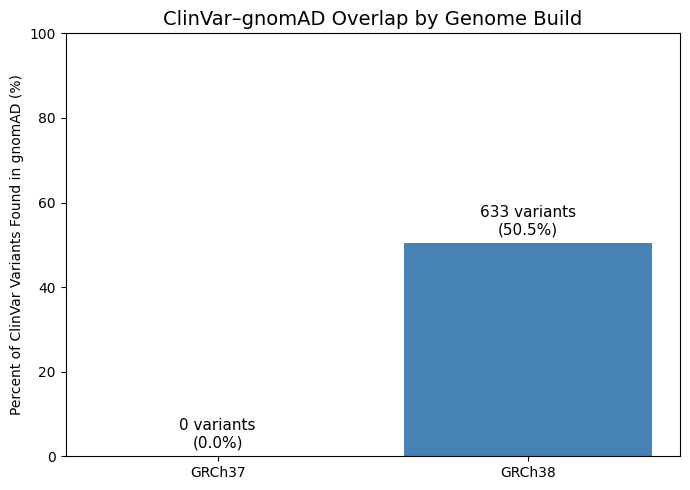

In [117]:
import matplotlib.pyplot as plt

# === Data from your merge summary ===
results = {
    "GRCh37": 0,
    "GRCh38": 633
}

clinvar_total = 1253  # total ClinVar SNVs per build

# === Calculate percentages ===
percentages = {k: (v / clinvar_total) * 100 for k, v in results.items()}

# === Plot ===
plt.figure(figsize=(7,5))
bars = plt.bar(results.keys(), percentages.values(), color=["gray", "steelblue"])
plt.title("ClinVar–gnomAD Overlap by Genome Build", fontsize=14)
plt.ylabel("Percent of ClinVar Variants Found in gnomAD (%)")
plt.ylim(0, 100)

# Annotate bars with counts and percentages
for bar, build in zip(bars, results.keys()):
    val = results[build]
    pct = percentages[build]
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, f"{val} variants\n({pct:.1f}%)",
             ha='center', fontsize=11)

plt.tight_layout()
plt.show()


In [118]:
clinvar_total = 1253   # total ClinVar GRCh38 SNVs
gnomad_total = 2992    # total gnomAD SNVs
matches = 633          # matched variants from inner join

# === Compute metrics ===
clinvar_in_gnomad = matches / clinvar_total * 100
gnomad_in_clinvar = matches / gnomad_total * 100

clinvar_not_in_gnomad = clinvar_total - matches
gnomad_not_in_clinvar = gnomad_total - matches

# === Print summary ===
print("📊 Overlap Summary (GRCh38 coordinate-based merge)")
print(f"ClinVar total variants: {clinvar_total}")
print(f"gnomAD total variants: {gnomad_total}")
print(f"Matched variants: {matches}")
print(f"ClinVar NOT in gnomAD: {clinvar_not_in_gnomad}")
print(f"gnomAD NOT in ClinVar: {gnomad_not_in_clinvar}")
print(f"\nPercent of ClinVar found in gnomAD: {clinvar_in_gnomad:.2f}%")
print(f"Percent of gnomAD found in ClinVar: {gnomad_in_clinvar:.2f}%")


📊 Overlap Summary (GRCh38 coordinate-based merge)
ClinVar total variants: 1253
gnomAD total variants: 2992
Matched variants: 633
ClinVar NOT in gnomAD: 620
gnomAD NOT in ClinVar: 2359

Percent of ClinVar found in gnomAD: 50.52%
Percent of gnomAD found in ClinVar: 21.16%


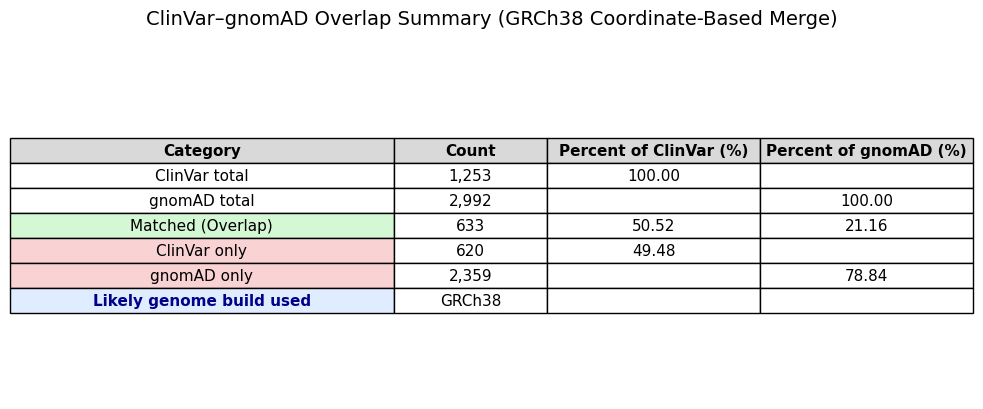

In [119]:
import matplotlib.pyplot as plt
import pandas as pd

# === Data from your analysis ===
clinvar_total = 1253
gnomad_total = 2992
matches = 633
clinvar_only = clinvar_total - matches
gnomad_only = gnomad_total - matches
likely_build = "GRCh38"

# === Build dataframe ===
data = {
    'Category': [
        'ClinVar total',
        'gnomAD total',
        'Matched (Overlap)',
        'ClinVar only',
        'gnomAD only',
        'Likely genome build used'
    ],
    'Count': [
        f"{clinvar_total:,}",
        f"{gnomad_total:,}",
        f"{matches:,}",
        f"{clinvar_only:,}",
        f"{gnomad_only:,}",
        likely_build
    ],
    'Percent of ClinVar (%)': [
        "100.00",
        "",
        f"{matches / clinvar_total * 100:.2f}",
        f"{clinvar_only / clinvar_total * 100:.2f}",
        "",
        ""
    ],
    'Percent of gnomAD (%)': [
        "",
        "100.00",
        f"{matches / gnomad_total * 100:.2f}",
        "",
        f"{gnomad_only / gnomad_total * 100:.2f}",
        ""
    ]
}

df = pd.DataFrame(data)

# === Create figure ===
fig, ax = plt.subplots(figsize=(11, 4.5))  # wider overall figure
ax.axis('tight')
ax.axis('off')

# === Create table ===
table = ax.table(
    cellText=df.values,
    colLabels=df.columns,
    loc='center',
    cellLoc='center',
    colLoc='center'
)

# === Style ===
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 1.5)

# === Manually widen columns ===
# These values correspond to each column: [Category, Count, ClinVar %, gnomAD %]
col_widths = [0.45, 0.18, 0.25, 0.25]  # increased last two columns
for i, width in enumerate(col_widths):
    for (row, col), cell in table.get_celld().items():
        if col == i:
            cell.set_width(width)

# === Apply color coding ===
for (row, col), cell in table.get_celld().items():
    text = str(cell.get_text().get_text())

    if row == 0:  # Header
        cell.set_facecolor('#d9d9d9')
        cell.set_text_props(weight='bold')

    elif 'Matched' in text:  # Overlap
        cell.set_facecolor('#d4f7d4')

    elif 'ClinVar only' in text or 'gnomAD only' in text:  # Unique
        cell.set_facecolor('#f9d3d3')

    elif 'Likely genome build used' in text:  # Build
        cell.set_facecolor('#e0ecff')
        cell.set_text_props(weight='bold', color='darkblue')

plt.title("ClinVar–gnomAD Overlap Summary (GRCh38 Coordinate-Based Merge)", fontsize=14, pad=20)
plt.show()


In [120]:
import pandas as pd

# ==============================================================
# STEP 1: Load datasets
# ==============================================================
clin = pd.read_csv("clinvar_result.txt", sep="\t", dtype=str, low_memory=False)
gnomad = pd.read_csv("gnomad_result.csv", dtype=str, low_memory=False)
merged = pd.read_csv("clinvar_gnomad_GRCh38_clinicalmerge.csv", dtype=str, low_memory=False)

print(f"✅ ClinVar loaded: {clin.shape[0]:,} rows")
print(f"✅ gnomAD loaded:  {gnomad.shape[0]:,} rows")
print(f"✅ Merged file loaded: {merged.shape[0]:,} rows")

# ==============================================================
# STEP 2: Clean and normalize columns
# ==============================================================
# --- ClinVar ---
clin["GRCh38Chromosome"] = clin["GRCh38Chromosome"].astype(str).str.replace("chr", "", regex=False)
clin["GRCh38Location"] = clin["GRCh38Location"].astype(str).str.extract(r"(\d+)", expand=False)
clin["GRCh38Location"] = pd.to_numeric(clin["GRCh38Location"], errors="coerce")

# Some ClinVar files may not have ref/alt, but if they do, normalize case
for col in ["Reference", "Alternate"]:
    if col in clin.columns:
        clin[col] = clin[col].astype(str).str.upper().str.strip()

# --- gnomAD ---
gnomad["Chromosome"] = gnomad["Chromosome"].astype(str).str.replace("chr", "", regex=False)
gnomad["Position"] = pd.to_numeric(gnomad["Position"], errors="coerce")
for col in ["Reference", "Alternate"]:
    if col in gnomad.columns:
        gnomad[col] = gnomad[col].astype(str).str.upper().str.strip()

# --- Merged normalized coordinates ---
merged["chrom_norm"] = merged["chrom_norm"].astype(str).str.replace("chr", "", regex=False)
merged["pos_norm"] = pd.to_numeric(merged["pos_norm"], errors="coerce")
merged["ref_norm"] = merged["ref_norm"].astype(str).str.upper().str.strip()
merged["alt_norm"] = merged["alt_norm"].astype(str).str.upper().str.strip()

# ==============================================================
# STEP 3: Create join keys for matching
# ==============================================================
def make_key(chrom, pos, ref, alt):
    return chrom.astype(str) + "_" + pos.astype(str) + "_" + ref.astype(str) + "_" + alt.astype(str)

# Build keys
if all(c in clin.columns for c in ["Reference", "Alternate"]):
    clin["join_key"] = make_key(clin["GRCh38Chromosome"], clin["GRCh38Location"], clin["Reference"], clin["Alternate"])
else:
    # fallback (coordinate only)
    clin["join_key"] = clin["GRCh38Chromosome"].astype(str) + "_" + clin["GRCh38Location"].astype(str)

gnomad["join_key"] = make_key(gnomad["Chromosome"], gnomad["Position"], gnomad["Reference"], gnomad["Alternate"])
merged["join_key"] = make_key(merged["chrom_norm"], merged["pos_norm"], merged["ref_norm"], merged["alt_norm"])

# ==============================================================
# STEP 4: Map genes from ClinVar into merged data
# ==============================================================
annotated = pd.merge(
    merged,
    clin[["join_key", "Gene(s)"]],
    on="join_key",
    how="left"
)

print(f"✅ Mapped genes for {annotated['Gene(s)'].notna().sum():,} variants")

# ==============================================================
# STEP 5: Check if any unmatched variants can be inferred via gnomAD
# ==============================================================
unmapped = annotated[annotated["Gene(s)"].isna()].copy()
if not unmapped.empty:
    print(f"ℹ️ Attempting to find genes for {len(unmapped):,} unmapped variants using gnomAD coordinates...")
    unmapped = pd.merge(
        unmapped.drop(columns=["Gene(s)"]),
        clin,
        left_on=["chrom_norm", "pos_norm"],
        right_on=["GRCh38Chromosome", "GRCh38Location"],
        how="left",
        suffixes=("", "_clinvar_match")
    )
    # Fill missing genes
    annotated.loc[annotated["Gene(s)"].isna(), "Gene(s)"] = unmapped["Gene(s)"]

# ==============================================================
# STEP 6: Summary
# ==============================================================
gene_counts = annotated["Gene(s)"].value_counts(dropna=True).reset_index()
gene_counts.columns = ["Gene", "Variant Count"]

print("\n🧾 Genes represented in normalized variants:")
print(gene_counts.head(15))

# ==============================================================
# STEP 7: Save output
# ==============================================================
annotated.to_csv("normalized_variants_with_genes.csv", index=False)
print("\n✅ Saved annotated dataset as: normalized_variants_with_genes.csv")

# ==============================================================
# STEP 8: Preview results
# ==============================================================
print("\n🔹 Example mapped variants:")
print(annotated[["chrom_norm", "pos_norm", "ref_norm", "alt_norm", "Gene(s)"]].head(15))


✅ ClinVar loaded: 1,435 rows
✅ gnomAD loaded:  2,992 rows
✅ Merged file loaded: 633 rows
✅ Mapped genes for 0 variants
ℹ️ Attempting to find genes for 633 unmapped variants using gnomAD coordinates...

🧾 Genes represented in normalized variants:
   Gene  Variant Count
0  HEXA            633

✅ Saved annotated dataset as: normalized_variants_with_genes.csv

🔹 Example mapped variants:
   chrom_norm  pos_norm ref_norm alt_norm Gene(s)
0          15  72344065        G        A    HEXA
1          15  72344080        G        A    HEXA
2          15  72344093        T        C    HEXA
3          15  72344095        C        T    HEXA
4          15  72344110        T        C    HEXA
5          15  72344111        A        G    HEXA
6          15  72344111        A        T    HEXA
7          15  72344113        A        G    HEXA
8          15  72344119        G        A    HEXA
9          15  72344122        T        C    HEXA
10         15  72344130        G        A    HEXA
11         15 

In [121]:
import pandas as pd

# ==============================================================
# STEP 1: Load normalized dataset
# ==============================================================
df = pd.read_csv("normalized_variants_with_genes.csv", dtype=str, low_memory=False)
print(f"✅ Loaded normalized dataset: {df.shape[0]:,} rows, {df.shape[1]:,} columns")

# ==============================================================
# STEP 2: Keep only HEXA variants
# ==============================================================
hexa = df[df["Gene(s)"].notna() & df["Gene(s)"].str.contains("HEXA", case=False, na=False)].copy()
print(f"🧬 HEXA variants found: {len(hexa):,}")

# ==============================================================
# STEP 3: Ensure coordinate and allele columns are properly formatted
# ==============================================================
hexa["pos_norm"] = pd.to_numeric(hexa["pos_norm"], errors="coerce")
for col in ["chrom_norm", "ref_norm", "alt_norm"]:
    hexa[col] = hexa[col].astype(str).str.strip().str.upper()

# ==============================================================
# STEP 4: Count frequency of each position first
# ==============================================================
pos_counts = hexa["pos_norm"].value_counts().reset_index()
pos_counts.columns = ["pos_norm", "Position_Count"]

hexa = hexa.merge(pos_counts, on="pos_norm", how="left")

# ==============================================================
# STEP 5: Then count frequency of each allele (ref+alt) within those positions
# ==============================================================
allele_counts = (
    hexa.groupby(["pos_norm", "ref_norm", "alt_norm"])
    .size()
    .reset_index(name="Allele_Count")
)

hexa = hexa.merge(allele_counts, on=["pos_norm", "ref_norm", "alt_norm"], how="left")

# ==============================================================
# STEP 6: Sort variants: first by position frequency, then allele count
# ==============================================================
hexa_sorted = hexa.sort_values(
    ["Position_Count", "Allele_Count"], ascending=[False, False]
).reset_index(drop=True)

print(f"📊 Sorted {len(hexa_sorted):,} HEXA variants by position and allele frequency")

# ==============================================================
# STEP 7: Add annotation count across identical allele keys
# ==============================================================
hexa_sorted["Annotation Count"] = hexa_sorted.groupby(
    ["chrom_norm", "pos_norm", "ref_norm", "alt_norm"]
)["pos_norm"].transform("count")

# ==============================================================
# STEP 8: Identify most frequently annotated pathogenic variants
# ==============================================================
path_col_candidates = [c for c in hexa_sorted.columns if "classif" in c.lower()]
path_col = path_col_candidates[0] if path_col_candidates else None

if path_col:
    pathogenic = hexa_sorted[hexa_sorted[path_col].str.contains("pathogenic", case=False, na=False)].copy()
    most_pathogenic = pathogenic.sort_values(
        ["Position_Count", "Allele_Count", "Annotation Count"],
        ascending=[False, False, False]
    ).head(1)
    print("\n🧬 Most Frequently Annotated Pathogenic HEXA Variant:")
    display(most_pathogenic[["chrom_norm", "pos_norm", "ref_norm", "alt_norm", "Position_Count", "Allele_Count", "Annotation Count", path_col]])
else:
    print("\n⚠️ No pathogenic classification column found.")

# ==============================================================
# STEP 9: Check for allele frequency column from gnomAD
# ==============================================================
af_col_candidates = [c for c in hexa_sorted.columns if "allele" in c.lower() and "freq" in c.lower()]
af_col = af_col_candidates[0] if af_col_candidates else None

if af_col:
    hexa_sorted[af_col] = pd.to_numeric(hexa_sorted[af_col], errors="coerce")
    print(f"📈 Using allele frequency column: {af_col}")
else:
    hexa_sorted["Allele Frequency"] = None
    af_col = "Allele Frequency"
    print("⚠️ No allele frequency column found; set to None")

# ==============================================================
# STEP 10: Create top 10 table (exclude unwanted columns)
# ==============================================================
top10 = (
    hexa_sorted.sort_values(
        ["Position_Count", "Allele_Count", "Annotation Count", af_col],
        ascending=[False, False, False, False]
    )
    .head(10)
    .reset_index(drop=True)
)

# Add rank from 1–10
top10.insert(0, "Rank", range(1, len(top10) + 1))

# Keep only the desired columns
top10_final = top10[["Rank", "chrom_norm", "pos_norm", "ref_norm", "Position_Count"]].drop_duplicates()

# Reset and drop index fully
top10_final = top10_final.reset_index(drop=True)

print("\n📋 Top 10 Most Frequently Altered HEXA Variants (Simplified):")
display(top10_final.style.hide(axis="index"))  # 👈 hides left index in Jupyter display

# ==============================================================
# STEP 11: Save for review (no index in CSV)
# ==============================================================
top10_final.to_csv("hexa_top10_by_position.csv", index=False)
print("\n✅ Saved simplified table as: hexa_top10_by_position.csv")


✅ Loaded normalized dataset: 633 rows, 78 columns
🧬 HEXA variants found: 633
📊 Sorted 633 HEXA variants by position and allele frequency

🧬 Most Frequently Annotated Pathogenic HEXA Variant:


,chrom_norm,pos_norm,ref_norm,alt_norm,Position_Count,Allele_Count,Annotation Count,ClinVar Germline Classification
5,15,72346220,C,G,3,1,1,Conflicting classifications of pathogenicity


📈 Using allele frequency column: Allele Frequency

📋 Top 10 Most Frequently Altered HEXA Variants (Simplified):


Rank,chrom_norm,pos_norm,ref_norm,Position_Count
1,15,72346221,C,3
2,15,72346220,C,3
3,15,72346220,C,3
4,15,72346220,C,3
5,15,72346221,C,3
6,15,72346216,C,3
7,15,72346216,C,3
8,15,72346216,C,3
9,15,72346221,C,3
10,15,72346318,A,2



✅ Saved simplified table as: hexa_top10_by_position.csv


In [122]:
import pandas as pd

# === Load merged CSV ===
merged38 = pd.read_csv("clinvar_gnomad_GRCh38_clinicalmerge.csv", dtype=str)

# === Check columns to confirm exact names ===
print("Columns in merged38:")
print(merged38.columns.tolist())

# === Filter for pathogenic variants ===
# Make sure to use the exact column name
pathogenic_variants = merged38[
    merged38['ClinVar Germline Classification'].str.contains('Pathogenic', case=False, na=False)
]

# === Display pathogenic variants only ===
print("\nPathogenic variants from ClinVar ↔ gnomAD merge:")
print(pathogenic_variants)

# === Optional: save pathogenic variants to a new CSV ===
pathogenic_csv = "pathogenic_variants_only.csv"
pathogenic_variants.to_csv(pathogenic_csv, index=False)
print(f"\n✅ Saved pathogenic variants to: {pathogenic_csv}")


Columns in merged38:
['chrom_norm', 'pos_norm', 'ref_norm', 'alt_norm', 'gnomAD ID', 'Chromosome', 'Position', 'rsIDs', 'Reference', 'Alternate', 'Source', 'Filters - exomes', 'Filters - genomes', 'Transcript', 'HGVS Consequence', 'Protein Consequence', 'Transcript Consequence', 'VEP Annotation', 'ClinVar Germline Classification', 'ClinVar Variation ID', 'Flags', 'Allele Count', 'Allele Number', 'Allele Frequency', 'Homozygote Count', 'Hemizygote Count', 'Filters - joint', 'GroupMax FAF group', 'GroupMax FAF frequency', 'cadd', 'revel_max', 'spliceai_ds_max', 'pangolin_largest_ds', 'phylop', 'sift_max', 'polyphen_max', 'Allele Count African/African American', 'Allele Number African/African American', 'Homozygote Count African/African American', 'Hemizygote Count African/African American', 'Allele Count Admixed American', 'Allele Number Admixed American', 'Homozygote Count Admixed American', 'Hemizygote Count Admixed American', 'Allele Count Ashkenazi Jewish', 'Allele Number Ashkenazi J

In [123]:
pip install tabulate



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [124]:
import pandas as pd

# === Load the pathogenic variants CSV ===
pathogenic = pd.read_csv("pathogenic_variants_only.csv", dtype=str)

# === Remove any entries with 'Conflicting' in the ClinVar Germline Classification ===
pathogenic = pathogenic[
    ~pathogenic['ClinVar Germline Classification'].str.contains('Conflicting', case=False, na=False)
]

# === Convert 'Allele Frequency' to numeric for proper sorting ===
pathogenic['Allele Frequency'] = pd.to_numeric(pathogenic['Allele Frequency'], errors='coerce')

# === Sort by Allele Frequency (descending) and get top 10 ===
top10 = pathogenic.sort_values('Allele Frequency', ascending=False).head(10).copy()

# === Add a rank column ===
top10.insert(0, 'Rank', range(1, len(top10) + 1))

# === Select columns to display ===
cols_to_show = [
    'Rank',
    'Allele Frequency',
    'chrom_norm',
    'pos_norm',
    'ref_norm',
    'alt_norm',
    'ClinVar Germline Classification',
    'gnomAD ID'
]

# === Format display ===
pd.set_option('display.float_format', '{:.3e}'.format)  # scientific notation
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# === Display the formatted table ===
print("\nTop 10 Pathogenic Variants by Allele Frequency (excluding 'Conflicting'):\n")
print(top10[cols_to_show].to_string(index=False))

# === Optional: Save to CSV ===
top10[cols_to_show].to_csv("top10_pathogenic_variants_by_AF.csv", index=False)
print("\n✅ Saved top 10 pathogenic variants to: top10_pathogenic_variants_by_AF.csv")



Top 10 Pathogenic Variants by Allele Frequency (excluding 'Conflicting'):

 Rank  Allele Frequency chrom_norm pos_norm ref_norm alt_norm ClinVar Germline Classification       gnomAD ID
    1         6.040e-04         15 72348047        C        T    Pathogenic/Likely pathogenic 15-72348047-C-T
    2         1.382e-04         15 72350518        C        T    Pathogenic/Likely pathogenic 15-72350518-C-T
    3         6.815e-05         15 72345476        C        T                      Pathogenic 15-72345476-C-T
    4         6.759e-05         15 72346234        C        G                      Pathogenic 15-72346234-C-G
    5         6.198e-05         15 72353105        C        T    Pathogenic/Likely pathogenic 15-72353105-C-T
    6         5.868e-05         15 72355562        G        A                      Pathogenic 15-72355562-G-A
    7         4.709e-05         15 72346263        C        T               Likely pathogenic 15-72346263-C-T
    8         3.966e-05         15 72346552 

In [125]:
import pandas as pd
from tabulate import tabulate  # for clean table display

# === Load the pathogenic variants CSV ===
pathogenic = pd.read_csv("pathogenic_variants_only.csv", dtype=str)

# === Remove any entries with 'Conflicting' in the ClinVar Germline Classification ===
pathogenic = pathogenic[
    ~pathogenic['ClinVar Germline Classification'].str.contains('Conflicting', case=False, na=False)
]

# === Convert 'Allele Frequency' to numeric for proper sorting ===
pathogenic['Allele Frequency'] = pd.to_numeric(pathogenic['Allele Frequency'], errors='coerce')

# === Sort by Allele Frequency (descending) and get top 10 ===
top10 = pathogenic.sort_values('Allele Frequency', ascending=False).head(10).copy()

# === Add a rank column ===
top10.insert(0, 'Rank', range(1, len(top10) + 1))

# === Select columns to display ===
cols_to_show = [
    'Rank',
    'Allele Frequency',
    'chrom_norm',
    'pos_norm',
    'ref_norm',
    'alt_norm',
    'ClinVar Germline Classification',
    'gnomAD ID'
]

# === Format allele frequency for scientific notation ===
top10['Allele Frequency'] = top10['Allele Frequency'].map(lambda x: f"{x:.3e}" if pd.notna(x) else "")

# === Display as a clean table ===
print("\nTop 10 Pathogenic Variants by Allele Frequency (excluding 'Conflicting'):\n")
print(tabulate(top10[cols_to_show], headers='keys', tablefmt='grid', showindex=False))

# === Save to CSV ===
top10[cols_to_show].to_csv("top10_pathogenic_variants_by_AF.csv", index=False)
print("\n✅ Saved top 10 pathogenic variants to: top10_pathogenic_variants_by_AF.csv")



Top 10 Pathogenic Variants by Allele Frequency (excluding 'Conflicting'):

+--------+--------------------+--------------+------------+------------+------------+-----------------------------------+-----------------+
|   Rank |   Allele Frequency |   chrom_norm |   pos_norm | ref_norm   | alt_norm   | ClinVar Germline Classification   | gnomAD ID       |
+========+====================+==============+============+============+============+===================================+=================+
|      1 |          0.000604  |           15 |   72348047 | C          | T          | Pathogenic/Likely pathogenic      | 15-72348047-C-T |
+--------+--------------------+--------------+------------+------------+------------+-----------------------------------+-----------------+
|      2 |          0.0001382 |           15 |   72350518 | C          | T          | Pathogenic/Likely pathogenic      | 15-72350518-C-T |
+--------+--------------------+--------------+------------+------------+------------

In [126]:
import pandas as pd

# === Load & clean ===
pathogenic = pd.read_csv("pathogenic_variants_only.csv", dtype=str)
pathogenic = pathogenic[
    ~pathogenic['ClinVar Germline Classification'].str.contains('Conflicting', case=False, na=False)
]
pathogenic['Allele Frequency'] = pd.to_numeric(pathogenic['Allele Frequency'], errors='coerce')
pathogenic['Carrier Frequency (%)'] = pathogenic['Allele Frequency'] * 2 * 100
pathogenic['GroupMax FAF frequency'] = pd.to_numeric(pathogenic['GroupMax FAF frequency'], errors='coerce')

# === Rank & sort ===
top10 = pathogenic.sort_values('Allele Frequency', ascending=False).head(10).copy()
top10.insert(0, 'Rank', range(1, len(top10) + 1))

# === Columns to include ===
cols_to_show = [
    'Rank', 'chrom_norm', 'pos_norm', 'ref_norm', 'alt_norm',
    'ClinVar Germline Classification', 'VEP Annotation', 'Protein Consequence',
    'Allele Frequency', 'Carrier Frequency (%)', 'Allele Count', 'Allele Number',
    'GroupMax FAF group', 'GroupMax FAF frequency', 'cadd', 'spliceai_ds_max', 'gnomAD ID'
]

# === Clean column labels ===
pretty_labels = {
    'chrom_norm': 'Chr',
    'pos_norm': 'Pos',
    'ref_norm': 'Ref',
    'alt_norm': 'Alt',
    'ClinVar Germline Classification': 'ClinVar Class',
    'VEP Annotation': 'VEP',
    'Protein Consequence': 'Protein Change',
    'Allele Frequency': 'AF',
    'Carrier Frequency (%)': 'Carrier Freq (%)',
    'Allele Count': 'AC',
    'Allele Number': 'AN',
    'GroupMax FAF group': 'Max Group',
    'GroupMax FAF frequency': 'Max FAF',
    'cadd': 'CADD',
    'spliceai_ds_max': 'SpliceAI',
    'gnomAD ID': 'gnomAD ID'
}

# === Format numeric columns in scientific notation ===
num_cols = ['Allele Frequency', 'Carrier Frequency (%)', 'GroupMax FAF frequency', 'cadd', 'spliceai_ds_max']
for col in num_cols:
    if col in top10.columns:
        top10[col] = pd.to_numeric(top10[col], errors='coerce').map(lambda x: f"{x:.3e}" if pd.notna(x) else "")

# === Rename for display ===
top10 = top10[cols_to_show].rename(columns=pretty_labels)

# === Clean, rich HTML display with wider AF and Carrier Freq columns ===
styled = (
    top10.style
    .set_caption("🧬 Top 10 Pathogenic Variants by Allele Frequency (Scientific Notation)")
    .set_table_styles([
        {"selector": "caption", "props": [("font-size", "16px"), ("font-weight", "bold"), ("text-align", "left")]},
        {"selector": "th", "props": [("background-color", "#e8f0fe"), ("font-weight", "bold"), ("text-align", "center")]},
        {"selector": "td", "props": [("text-align", "center")]},
        {"selector": "th.col0, td.col0", "props": [("min-width", "50px")]},    # Rank
        {"selector": "th.col8, td.col8", "props": [("min-width", "120px")]},   # AF
        {"selector": "th.col9, td.col9", "props": [("min-width", "140px")]},   # Carrier Freq (%)
        {"selector": "th.col12, td.col12", "props": [("min-width", "120px")]}, # Max FAF
        {"selector": "th.col16, td.col16", "props": [("min-width", "160px")]}  # gnomAD ID
    ])
    .background_gradient(subset=["AF"], cmap="Blues")
)


styled


,Rank,Chr,Pos,Ref,Alt,ClinVar Class,VEP,Protein Change,AF,Carrier Freq (%),AC,AN,Max Group,Max FAF,CADD,SpliceAI,gnomAD ID
38,1,15,72348047,C,T,Pathogenic/Likely pathogenic,splice_donor_variant,nan,6.040e-04,1.208e-01,968,1602712,nfe,7.519e-04,3.400e+01,9.300e-01,15-72348047-C-T
57,2,15,72350518,C,T,Pathogenic/Likely pathogenic,missense_variant,p.Gly269Ser,1.382e-04,2.764e-02,223,1613890,nfe,1.350e-04,3.300e+01,2.000e-02,15-72350518-C-T
6,3,15,72345476,C,T,Pathogenic,missense_variant,p.Arg499His,6.815e-05,1.363e-02,110,1614084,sas,2.739e-04,2.910e+01,4.000e-02,15-72345476-C-T
15,4,15,72346234,C,G,Pathogenic,splice_donor_variant,nan,6.759e-05,1.352e-02,109,1612550,nfe,2.470e-06,3.400e+01,9.900e-01,15-72346234-C-G
84,5,15,72353105,C,T,Pathogenic/Likely pathogenic,missense_variant,p.Arg178His,6.198e-05,1.240e-02,100,1613298,nfe,6.051e-05,3.000e+01,9.000e-02,15-72353105-C-T
94,6,15,72355562,G,A,Pathogenic,stop_gained,p.Arg137Ter,5.868e-05,1.174e-02,94,1601902,nfe,6.286e-05,3.800e+01,1.200e-01,15-72355562-G-A
17,7,15,72346263,C,T,Likely pathogenic,missense_variant,p.Asp465Asn,4.709e-05,9.419e-03,76,1613822,nfe,5.193e-05,2.830e+01,0.000e+00,15-72346263-C-T
24,8,15,72346552,G,A,Pathogenic/Likely pathogenic,synonymous_variant,p.Tyr435Tyr,3.966e-05,7.931e-03,64,1613896,afr,3.682e-04,1.570e+01,1.400e-01,15-72346552-G-A
90,9,15,72353667,C,G,Pathogenic,intron_variant,nan,3.090e-05,6.179e-03,49,1585964,nfe,3.137e-05,3.570e+00,0.000e+00,15-72353667-C-G
42,10,15,72349076,T,C,Pathogenic/Likely pathogenic,intron_variant,nan,2.914e-05,5.828e-03,47,1612988,nfe,2.910e-05,2.500e+01,5.900e-01,15-72349076-T-C
